In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

# Создание Dataloader

In [2]:
def get_nonzero_target_values(target):
    target = dict(target)
    
    nonzero_indexes = torch.nonzero(target["boxes"], as_tuple=True)[0]
    target["boxes"] = torch.index_select(target["boxes"], 0, nonzero_indexes)
    target["labels"] = torch.index_select(target["labels"], 0, nonzero_indexes)
    return target

In [3]:
class FaceMaskDataset(torch.utils.data.Dataset):
    """ Dataset for mask dataset: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
        
        Args:
            root (str): Path of dataset on local
            transforms (transforms.Compose, optional): Transforms functions, witch take (img, target), modify they and return new (img, target)
            slice_vals (touple(int, int), optional): How shuffle dataset would be cut. For example, (0, 0.8) - take first 80% of dataset.
            max_boxes (int, optional): Max boxes on one picture.
    """
    
    def __init__(self, root, transforms = None, slice_vals = None, max_boxes = 128):
        
        self.root = root
        self.transforms = transforms
        self.max_boxes = max_boxes
        annotations_path = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        if slice_vals:
            size = len(annotations_path)
            annotations_path = annotations_path[int(size*slice_vals[0]) : int(size*slice_vals[1])]
        annotations = [self.__xml_to_dict(os.path.join(self.root, "annotations", path)) for path in annotations_path]
        self.targets = []
        for idx, annotation in enumerate(annotations):
            boxes = annotation["bndboxes"]
            labels = annotation["labels"]
            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            # Вычисление площади бокса для loss функции
            # area = boxes[:, 2] * boxes[:, 3]
            # suppose all instances are not crowd
            # iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            # target["area"] = area
            self.targets.append(target)
        self.images = []
        for img_path in [os.path.join(self.root, annotation["image_path"]) for annotation in annotations]:
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = np.array(img)
            self.images.append(img)
            
            
    def __getitem__(self, idx):
        # load images and masks
        img = self.images[idx].copy()
        target = dict(self.targets[idx])
        
        if self.transforms is not None:
            img, target = self.transforms((img, target))
        
        num_boxes = target["boxes"].shape[0]
        if self.max_boxes-num_boxes > 0:
            boxes = target["boxes"]
            labels = target["labels"]
            boxes = torch.cat((boxes, 
                               torch.zeros([self.max_boxes-num_boxes, 4], dtype=torch.float32)
                              ), 
                              dim=0)
            labels = torch.cat((labels, 
                                torch.zeros([self.max_boxes-num_boxes], dtype=torch.uint8)
                               ), 
                               dim=0)
            target["boxes"] = boxes
            target["labels"] = labels
        elif self.max_boxes-num_boxes < 0:
            raise Exception(f"Real boxes [{num_boxes}] greater than argument 'max_boxes'")
        # print(img.shape, target)
        return img, target

    def __len__(self):
        return len(self.targets)
    
    def __xml_to_dict(self, xml_file_path: str):
        """Parse .xml file in the xml_file_path, and return annotation with 
        "bndboxes": (x_cent,y_cent,width,height), "labels": (class), for each boxes in .xml file
        and "image_path" with target images.
        """ 
        class_mapping = {'with_mask' : 1,
                         'without_mask' : 0,
                         'mask_weared_incorrect' : 0}

        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        output = {}
        output["image_path"] = os.path.join(root.find("folder").text, root.find("filename").text)
        width, height = int(root.find('size')[0].text), int(root.find("size")[1].text)
        output["labels"] = []
        output["bndboxes"] = []
        for member in root.findall("object"):
            output["labels"].append(class_mapping.get(member[0].text))

            bndbox = [float(elem.text) for elem in member.find("bndbox")]
            bndbox_convert = self.__convert((width, height), bndbox)
            output["bndboxes"].append(bndbox_convert)

        return output
    
    def __convert(self, size: tuple, box: list):
        """Takes as input:  (width, height) of an image
                            (xmin, ymin, xmax, ymax) of the bounding box
           and returns (x, y, w, h) of the bounding box in yolo format.
        """   
        dw = 1./size[0]
        dh = 1./size[1]
        x = box[0]
        y = box[1]
        w = abs(box[2] - box[0])
        h = abs(box[3] - box[1])
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh

        return (x, y, w, h)

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size: tuple):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):
        img, target = data
        # print("Rescale:", target)
        h, w = img.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = cv.resize(img, (new_w, new_h))

        return img, target


class RandomHorizontalFlip(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __call__(self, data):
        img, target = data
        # print("RandomHorizontalFlip:", target)
        # Рандомная генерация из [0, 1]
        if np.random.choice(2, 1)[0]:
            img = cv.flip(img, 1)
            for i, box in enumerate(target["boxes"]):
                target["boxes"][i][0] = 1 - box[0] - box[2]
        return img, target
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        img, target = data
        # print("RandomCrop:", target)
        h, w = img.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img = img[top: top + new_h,
                      left: left + new_w]
        # Производим сдвиг
        boxes = target["boxes"] * torch.tensor([w, h, w, h]) - torch.tensor([left, top, 0, 0])
        # Преобразуем данные к координатам нового изображения
        boxes = boxes * torch.tensor([1 / new_w, 1 / new_h, 1 / new_w, 1 / new_h])
        # print("boxes:", boxes)
        # Уберём лишние боксы, которые за границей
        labels = target["labels"]
        real_boxes = []
        real_labels = []
        for i, box in enumerate(boxes):
            if box[0] > 1 or box[1] > 1:
                    continue
            if box[0] + box[2] <= 0 or box[1] + box[3] <= 0:
                    continue
            if box[0] < 0 or box[0] + box[2] > 1 or box[1] < 0 or box[1] + box[3] > 1:
                new_box = box.clone().detach()
                if box[0] < 0:
                    new_box[2] = box[2] + box[0] 
                    new_box[0] = 0
                else: 
                    new_box[0] = box[0]
                if box[1] < 0:
                    new_box[3] = box[3] + box[1] 
                    new_box[1] = 0
                else: 
                    new_box[1] = box[1]
                new_box[2] = 1 - box[0] if box[0] + box[2] > 1 else new_box[2]
                new_box[3] = 1 - box[1] if box[1] + box[3] > 1 else new_box[3]
                # IoU new box
                if (new_box[2]*new_box[3])/(box[2]*box[3]) < 0.6: 
                    continue
                else:
                    box = new_box
            real_boxes.append(box)
            real_labels.append(labels[i])
        # print("real_boxes:", real_boxes)
        # print("real_labels:", real_labels)
        if not real_boxes:
            target["boxes"] = torch.tensor([])
            target["labels"] = torch.tensor([])
        else:
            target["boxes"] = torch.stack(real_boxes)
            target["labels"] = torch.tensor(real_labels)
            
        return img, target
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        img, target = data
        # print("ToTensor:", target)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        # img = img.transpose((2, 0, 1))
        # img = torch.as_tensor(img, dtype=torch.uint8)
        img = transforms.ToTensor()(img)
        return img, target
    
class XYToCenter(object):
    """Convert xy(top_left))wh to xy(center)wh."""
    def __call__(self, data):
        img, target = data
        for i in range(len(target["boxes"])):
            box = target["boxes"][i]
            box[0] = box[0] + box[2]/2
            box[1] = box[1] + box[3]/2
            target["boxes"][i] = box
        
        return img, target

In [5]:
def img_with_box(img, boxes, labels, box_scale=True):
    """Draw boxes on image"""
    img = img.numpy().transpose((1, 2, 0)).copy() 
    # Рисуем боксы
    img_height, img_width = img.shape[:2]
    for label, box in zip(labels, boxes):
        color = (0,255,0) if label else (255,0,0)
        label = "with mask" if label else "without mask"
        x, y, w, h = box[0] - box[2]/2, box[1] - box[3]/2, box[2], box[3]
        if box_scale:
            x, y, w, h = int((box[0] - box[2]/2) * img_width), int((box[1] - box[3]/2) * img_height), int(box[2] * img_width), int(box[3] * img_height)
        else:
            x, y, w, h = int(x), int(y), int(w), int(h)
        # print(x, y, w, h)
        cv.rectangle(img,(x,y),(x+w,y+h), color, 2)
        cv.putText(img, label,(x,y - 10),0,0.4,color)
    return img
    # plt.figure(figsize=(0.02*img_width, 0.02*img_height))
    # plt.axis('off')
    # plt.imshow(img)
    # plt.show()
    # print("Image size: ", (img_width, img_height))

In [6]:
def show_img_with_box(img, target):
    """Draw boxes on image and show it"""
    target = dict(target)
    target = get_nonzero_target_values(target)
    print_img = img_with_box(img, target["boxes"], target["labels"])
    img_height, img_width = print_img.shape[:2]
    plt.figure(figsize=(0.02*img_width, 0.02*img_height))
    plt.axis('off')
    plt.imshow(print_img)
    plt.show()
    print("Image size: ", (img_width, img_height))

Разделим датасет на обучающий и тестовый (валидация и тест)
Для обучающего набора добавим аугментацию ввиде случайного обрезания и случайного зеркального отражения по горизонали

In [7]:
train_dataset = FaceMaskDataset("../dataset", 
                                  transforms = transforms.Compose([
                                       Rescale(800),
                                       RandomCrop(640),
                                       RandomHorizontalFlip(),
                                       XYToCenter(),
                                       ToTensor()
                                  ]),
                                  slice_vals = (0, 0.8)  
                               )
test_dataset = FaceMaskDataset("../dataset", 
                                  transforms = transforms.Compose([
                                       Rescale(680),
                                       RandomCrop(640),
                                       XYToCenter(),
                                       ToTensor()
                                  ]),
                                  slice_vals = (0.8, 1.0)  
                              )

Проверим работу аугментации

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


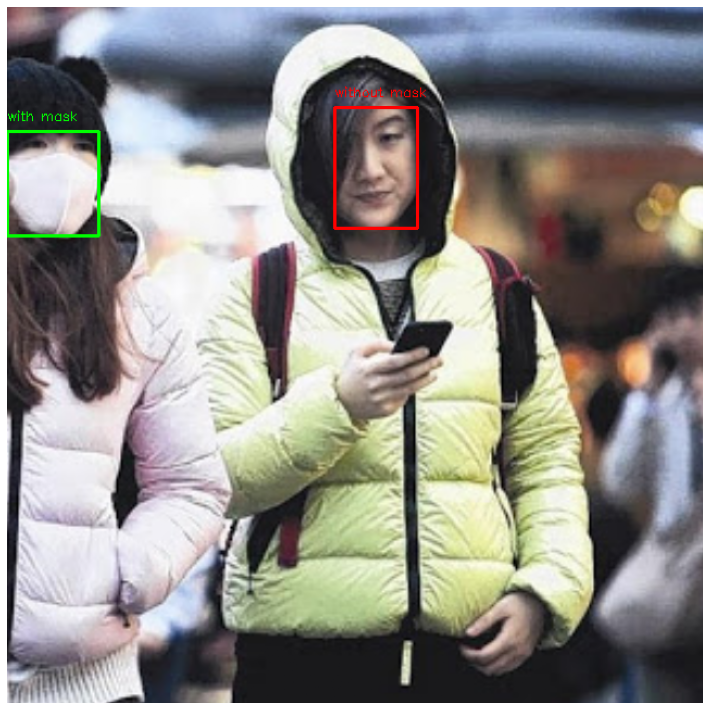

Image size:  (640, 640)


In [8]:
show_img_with_box(*train_dataset[0])

Разделение датасета по DataLoader

In [9]:
test_dataset_size = len(test_dataset)
valid_size = int(0.6 * test_dataset_size)
test_size  = int(0.4 * test_dataset_size)
test_size += test_dataset_size - valid_size - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

In [10]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

Проверим изображения в train батче

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


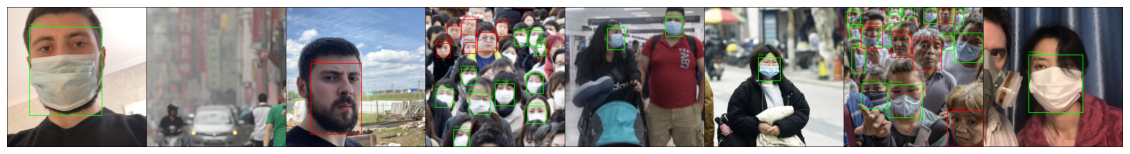

In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 12))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001)
    plt.show()


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, targets = next(iter(train_dl))
targets = [{"boxes": boxes, "labels": labels, "image_id": image_id}
                   for boxes, labels, image_id in 
                       zip(targets["boxes"], targets["labels"], targets["image_id"])]

# Расположим картинки рядом
targets = [get_nonzero_target_values(target) for target in targets]
out = [img_with_box(img, target["boxes"], target["labels"]) for img, target in zip(inputs, targets)]
out = utils.make_grid([torch.as_tensor(img.transpose((2, 0, 1)), dtype=torch.float32) for img in out])

imshow(out)

## Модель

In [12]:
import sys
sys.path.append("../yolov5")

In [13]:
from torch import nn, optim
from torch.cuda import amp
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from datetime import datetime

from utils.loss import ComputeLoss
from utils.metrics import ConfusionMatrix, ap_per_class, fitness
from utils.general import non_max_suppression, xywh2xyxy, xyxy2xywh
from models.common import AutoShape
from val import process_batch

Загрузим предобученную моедль и проверим её работу

In [16]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Domni/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  b9c498d torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [17]:
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

# Inference
results = model(imgs)

image 1/1: 720x1280 2 persons, 1 tie
Speed: 1366.1ms pre-process, 10505.6ms inference, 605.9ms NMS per image at shape (1, 3, 384, 640)


xmin        ymin         xmax        ymax  confidence  class    name
0  748.428772   43.683044  1139.243164  708.835938    0.941596      0  person
1  136.491333  200.489319  1110.013550  712.525269    0.891210      0  person
2  434.589050  437.347290   524.809387  715.899170    0.815259     27     tie

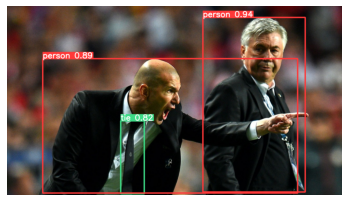

In [18]:
# Results
results.print()
plt.axis('off')
plt.imshow(results.render()[0])  # or .show()

# results.xyxy[0] # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

# Обучение модели

Попробуем адаптировать обучение модели для обучения в тетрадке

In [14]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [15]:
class EarlyStopping:
    """ YOLOv5 simple early stopper """
    def __init__(self, patience=30):
        self.best_fitness = 0.0  # i.e. mAP
        self.best_epoch = 0
        self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop
        self.possible_stop = False  # possible stop may occur next epoch

    def __call__(self, epoch, fitness):
        if fitness >= self.best_fitness:  # >= 0 to allow for early zero-fitness stage of training
            self.best_epoch = epoch
            self.best_fitness = fitness
        delta = epoch - self.best_epoch  # epochs without improvement
        self.possible_stop = delta >= (self.patience - 1)  # possible stop may occur next epoch
        stop = delta >= self.patience  # stop training if patience exceeded
        if stop:
            print(f'Stopping training early as no improvement observed in last {self.patience} epochs. '
                        f'Best results observed at epoch {self.best_epoch}, best model saved as best.pt.\n')
        return stop

In [16]:
def batch_target_transform(targets):
    """ conveet "boxes", "labels" to array of tensor(img_id, class, x, y, h, w) - boxes array """
    batch_box_arrays = []
    batch_size = targets["boxes"].shape[0]
    for i in range(batch_size):
        boxes = targets["boxes"][i]
        labels = targets["labels"][i]
        # Non-empty boxes
        nonzero_indexes = torch.nonzero(boxes, as_tuple=True)[0]
        boxes = torch.index_select(boxes, 0, nonzero_indexes)
        labels = torch.index_select(labels, 0, nonzero_indexes)
        num_boxes = boxes.shape[0]

        batch_boxes = torch.cat((torch.tensor(i).repeat(num_boxes).reshape((-1, 1)), 
                                 labels.reshape((-1, 1)), 
                                 boxes), 
                                dim=1
                               )
        batch_box_arrays.append(batch_boxes)
    return torch.cat(batch_box_arrays)

In [17]:
def batch_test_imgs(imgs, predictions):
    """ Draw boxes on images and concatinate they in one tensor image """
    box_imgs = []
    for img, predict in zip (imgs, predictions):
        # print("predict", predict)
        # print("shape", predict.shape)
        predict = predict.cpu()
        boxes = predict[:, :4]
        labels = predict[:, 5]
        predict = xyxy2xywh(predict)
        # labels = torch.max(predict[:][5:], 1).indices
        # print("boxes", boxes)
        # print("labels",labels)
        img = img_with_box(img, boxes, labels, box_scale = False)
        box_imgs.append(img)
    out = utils.make_grid([torch.as_tensor(img.transpose((2, 0, 1)), dtype=torch.float32) for img in box_imgs])
    return out

In [59]:
def fit(epochs, model, train_dl, valid_dl, log_dir = "../logs", save_dir = "../data"):
    """ Yolo fit
        
        Args:
            epochs (int): Number of fit epoch
            model (nn.Module): Yolov5 model to fit
            train_dl (DataLoadet): Train dataloader
            valid_dl (DataLoadet): Dataloader for model test
            log_dir (str, optional): Path to save TensorBoard logs
            save_dir (str, optional): Path to save weight
    """
    nc = model.yaml['nc'] # classes
    # hyperparam
    model.hyp = {
                'fl_gamma': 0,  # focal loss gamma (efficientDet default gamma=1.5)
                'box': 0.05,  # box loss gain
                'cls': 0.5,  # cls loss gain
                'anchor_t': 4.0,  # anchor-multiple threshold
                'cls_pw': 1.0,  # cls BCELoss positive_weight
                'obj': 1.0,  # obj loss gain (scale with pixels)
                'obj_pw': 1.0,  # obj BCELoss positive_weight
                'l_r': 0.01,   # Learning rate
                'lrf': 0.01,    # Final learning rate (l_r * lrf)
                'weight_decay': 0.0005,  # optimizer weight decay 5e-4
                'iou_thres': 0.65,  # NMS IoU threshold
                'conf_thres': 0.005,  # confidence threshold
                }
    
    # Directories to save model
    w = Path(save_dir) / 'weights'  # weights dir
    w.mkdir(parents=True, exist_ok=True)  # make dir
    last_model_dir, best_model_dir = w / 'last.pt', w / 'best.pt'
    
    # EarlyStopping params
    last_opt_step = 0
    best_fitness = 0 
    stopper = EarlyStopping()
    save_period = 100

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / train_dl.batch_size), 1)  # accumulate loss before optimizing
    model.hyp['weight_decay'] *= train_dl.batch_size * accumulate / nbs  # scale weight_decay
    
    g0, g1, g2 = [], [], []  # optimizer parameter groups
    for v in model.modules():
        if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):  # bias
            if (next (v.parameters())).requires_grad:
                g2.append(v.bias)
        if isinstance(v, nn.BatchNorm2d):  # BatchNorm weight
            if (next (v.parameters())).requires_grad:
                g0.append(v.weight)
        elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):  # weight
            if (next (v.parameters())).requires_grad:
                g1.append(v.weight)
    optimizer = optim.Adam(g0, lr=model.hyp['l_r'])
    optimizer.add_param_group({'params': g1, 'weight_decay': model.hyp['weight_decay']})  # add g1 with weight_decay
    optimizer.add_param_group({'params': g2})  # add g2 (biases)
    del g0, g1, g2
    # optimizer = optim.Adam(model.model.parameters(), lr=model.hyp['l_r'])
    # scheduler
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    lf = lambda x: (1 - x / epochs) * (1.0 - model.hyp['lrf']) + model.hyp['lrf']  # linear
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)
    
    
    compute_loss = ComputeLoss(model)  # init loss class
    scaler = amp.GradScaler()  # gradient scaler for use with autocat
    
    writer = SummaryWriter(log_dir) # Tensorboard
    
    # Start fit
    for epoch in range(epochs):
        print("Epoch", epoch)
        # Train
        model.train()
        epoch_train_loss = torch.zeros(3, device=device) # train loss
        for idx, (imgs, targets) in enumerate(tqdm(train_dl)):
            #
            batch_size = imgs.shape[0]
            imgs = imgs.to(device)
            targets = batch_target_transform(targets).to(device)
            # Forward
            with amp.autocast():
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets)  # loss scaled by batch_size
                epoch_train_loss += loss_items
            
            # Backward
            scaler.scale(loss).backward()
            # loss.backward()

            # Optimize (each accumulate step)
            if idx - last_opt_step >= accumulate:
                # optimizer.step()
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                last_opt_step = idx
                
        epoch_train_loss = epoch_train_loss.cpu() / len(train_dl)
        scheduler.step()
            

        # Valid
        model.eval()
        results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
        p, r, f1, mp, mr, map50, map5095 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        
        names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)} # class names
        iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
        niou = iouv.numel()
        epoch_valid_loss = torch.zeros(3, device=device) # valid model loss
        # confusion_matrix = ConfusionMatrix(nc=nc)
        stats = [] # statistic on valid dataset
        
        is_save_batch_images = False
        with torch.no_grad():
            for idx, (imgs, targets) in enumerate(tqdm(valid_dl)):
                batch_size = imgs.shape[0]
                imgs = imgs.to(device)
                targets = batch_target_transform(targets).to(device)

                # with amp.autocast():
                bach_boxes, pred = model(imgs)
                epoch_valid_loss += compute_loss(pred, targets)[1]
                # boxes = pred.reshape(batch_size, -1, pred.shape[-1])
                
                # Non-Max-Suppression
                height, width = imgs.shape[-2:]
                # to pixels
                targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)
                if idx == 0 and epoch == epochs - 1:
                    print('before')
                    print_bach_boxes = non_max_suppression(bach_boxes, 
                                                 0, 
                                                 0,
                                                 multi_label=True
                                                )
                    print(print_bach_boxes)
                    imshow(batch_test_imgs(imgs.cpu(), print_bach_boxes))
                    del print_bach_boxes
                bach_boxes = non_max_suppression(bach_boxes, 
                                                 model.hyp['conf_thres'], 
                                                 model.hyp['iou_thres'],
                                                 multi_label=True
                                                )
                if idx == 0 and epoch == epochs - 1:
                    print('after')
                    print(bach_boxes)
                    imshow(batch_test_imgs(imgs.cpu(), bach_boxes))
                # Save model predict in Tensorboard
                if epoch % 30 == 0 and not is_save_batch_images: 
                    writer.add_image('Images/valid_batch_image', batch_test_imgs(imgs.cpu(), bach_boxes), epoch)
                    is_save_batch_images = True
                
                # Metrics
                # for each img in batch
                for si, boxes in enumerate(bach_boxes): # for each img in batch
                    labels = targets[targets[:, 0] == si, 1:] # find true boxes for current img
                    nl = len(labels)
                    tcls = labels[:, 0].tolist() if nl else []  # target class
                    
                    # if model didn't find boxes
                    if len(boxes) == 0:
                        if nl:
                            stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                        continue
                        
                    # Predictions
                    boxesn = boxes.clone()
                    # Scale prediction coordunates
                    boxesn[:, :4] *= torch.Tensor([width, height, width, height]).to(device)

                    # Evaluate
                    if nl:
                        tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                        tbox *= torch.Tensor([width, height, width, height]).to(device)
                        labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                        correct = process_batch(boxesn, labelsn, iouv)
                    else:
                        correct = torch.zeros(boxes.shape[0], niou, dtype=torch.bool)
                    stats.append((correct.cpu(), boxes[:, 4].cpu(), boxes[:, 5].cpu(), tcls))  # (correct, conf, pcls, tcls)
                
            # Compute metrics
            stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
            if len(stats) and stats[0].any():
                tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names)
                ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
                mp, mr, map50, map5095 = p.mean(), r.mean(), ap50.mean(), ap.mean()
                nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
            else:
                nt = torch.zeros(1)
            result = (mp, mr, map50, map5095, *(epoch_valid_loss.cpu() / len(valid_dl)).tolist())
            # print("P, R, mAP@.5, mAP@.5-.95:")
            # print(result[:4])
            
            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            if fi > best_fitness:
                best_fitness = fi
                
            # Tensorboard save loss and metrics
            writer.add_scalars('Loss/loss_box', {'train':epoch_train_loss[0], 'valid':result[4]}, epoch)
            writer.add_scalars('Loss/loss_obj', {'train':epoch_train_loss[1], 'valid':result[5]}, epoch)
            writer.add_scalars('Loss/loss_cls', {'train':epoch_train_loss[2], 'valid':result[6]}, epoch)
            writer.add_scalar('Metrics/precision_mean', result[0], epoch)
            writer.add_scalar('Metrics/recall_mean', result[1], epoch)
            writer.add_scalar('Metrics/mAP@.5', result[2], epoch)
            writer.add_scalar('Metrics/mAP@.5-.95', result[3], epoch)
            
            
            # Save model
            ckpt = {'epoch': epoch,
                    'best_fitness': best_fitness,
                    'model': deepcopy(model).half(),
                    'optimizer': optimizer.state_dict(),
                    'date': datetime.now().isoformat()}

            # Save last, best and save_period
            torch.save(ckpt, last_model_dir)
            if best_fitness == fi:
                torch.save(ckpt, best_model_dir)
            if (epoch > 0) and (save_period > 0) and (epoch % save_period == 0):
                torch.save(ckpt, w / f'epoch{epoch}.pt')
                    
            # Stop fit
            if (epoch == epochs-1) or stopper(epoch, best_fitness):
                # Tensorboard write hyperparam
                writer.add_hparams(
                    {'epoch': epoch, 
                     'lr': model.hyp['l_r'], 
                     'iou_thres': model.hyp['iou_thres'], 
                     'conf_thres': model.hyp['conf_thres']
                    }, # huperparams
                    {'hparam/p_mean': result[0], 
                     'hparam/r_mean': result[1], 
                     'hparam/mAP@.5': result[2], 
                     'hparam/mAP@.5-.95': result[3]
                    } # metrics
                ) 
                break
        
        writer.close()

Получим модель для обучения

In [63]:
def get_finetune_yolo():
    model = torch.hub.load('../yolov5', 'yolov5s', source='local', classes=2, autoshape=False, pretrained=True)
    # Замораживаем слои
    # for param in model.model[:-1].parameters():
    #     param.requires_grad = False
    # for param in model.model[-1].m.parameters():
    #     param.requires_grad = True
    model.names = ["without mask", "with mask"]
    return model.to(device)

In [64]:
model = get_finetune_yolo()

YOLOv5  b9c498d torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   118

Получим информацию о модели

In [28]:
from utils.torch_utils import model_info
model_info(model.model, verbose=True)

Model Summary: 269 layers, 7025023 parameters, 7025023 gradients


layer                                     name  gradient   parameters                shape         mu      sigma
    0                            0.conv.weight      True         3456        [32, 3, 6, 6]   -0.00084      0.102
    1                              0.bn.weight      True           32                 [32]       2.32       1.11
    2                                0.bn.bias      True           32                 [32]      0.387       2.81
    3                            1.conv.weight      True        18432       [64, 32, 3, 3]  -0.000239     0.0531
    4                              1.bn.weight      True           64                 [64]       2.76      0.647
    5                                1.bn.bias      True           64                 [64]      0.604       1.05
    6                        2.cv1.conv.weight      True         2048       [32, 64, 1, 1]    -0.0087      0.083
    7                          2.cv1.bn.weight      True           32                 [32]      

Обучим модель

Epoch 0


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.57it/s]


Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 41


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 42


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 43


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 44


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 45


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 46


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 47


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 48


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 49


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 50


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 51


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 52


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 53


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 54


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 55


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 56


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 57


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 58


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 59


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 60


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

before


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([[ 1.61323e+02,  3.32816e+02,  2.55044e+02,  4.06066e+02,  5.96282e-03,  1.00000e+00],
        [ 2.55098e+02,  3.64554e+02,  3.51875e+02,  4.38473e+02,  5.74990e-03,  1.00000e+00],
        [ 6.39507e+01,  3.32484e+02,  1.59683e+02,  4.06885e+02,  5.65851e-03,  1.00000e+00],
        [-3.04940e+00,  4.41008e+01,  9.78766e+01,  1.19361e+02,  5.46871e-03,  1.00000e+00],
        [ 1.25083e+02,  1.08229e+02,  2.25464e+02,  1.83007e+02,  5.46129e-03,  1.00000e+00],
        [ 2.52893e+02,  2.03932e+02,  3.53264e+02,  2.80560e+02,  5.24599e-03,  1.00000e+00],
        [ 9.45508e+01,  4.59344e+02,  1.92947e+02,  5.38053e+02,  5.14128e-03,  1.00000e+00],
        [ 3.82563e+02,  2.68644e+02,  4.80767e+02,  3.46319e+02,  4.98075e-03,  1.00000e+00],
        [ 1.25404e+02,  1.28943e+01,  2.25315e+02,  8.96971e+01,  4.97659e-03,  1.00000e+00],
        [ 5.42937e+02,  4.56892e+01,  6.40538e+02,  1.21233e+02,  4.95717e-03,  1.00000e+00],
        [-2.51418e+00,  2.36631e+02,  9.71485e+01,  3.15030

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.03it/s]


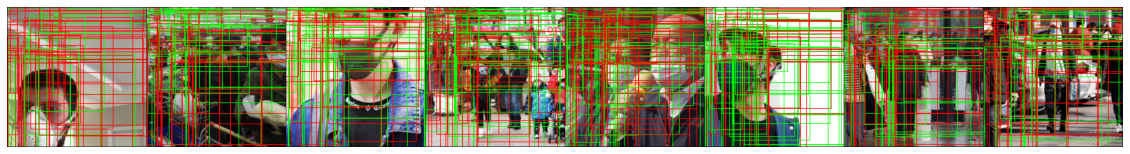

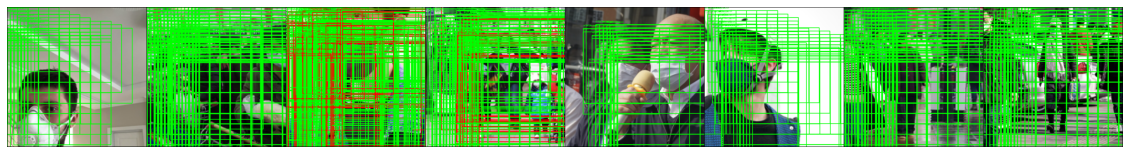

In [65]:
fit(61, model, train_dl, valid_dl, log_dir = "../logs/fit_6")

Посмотрим на ход обучения на tensorboard

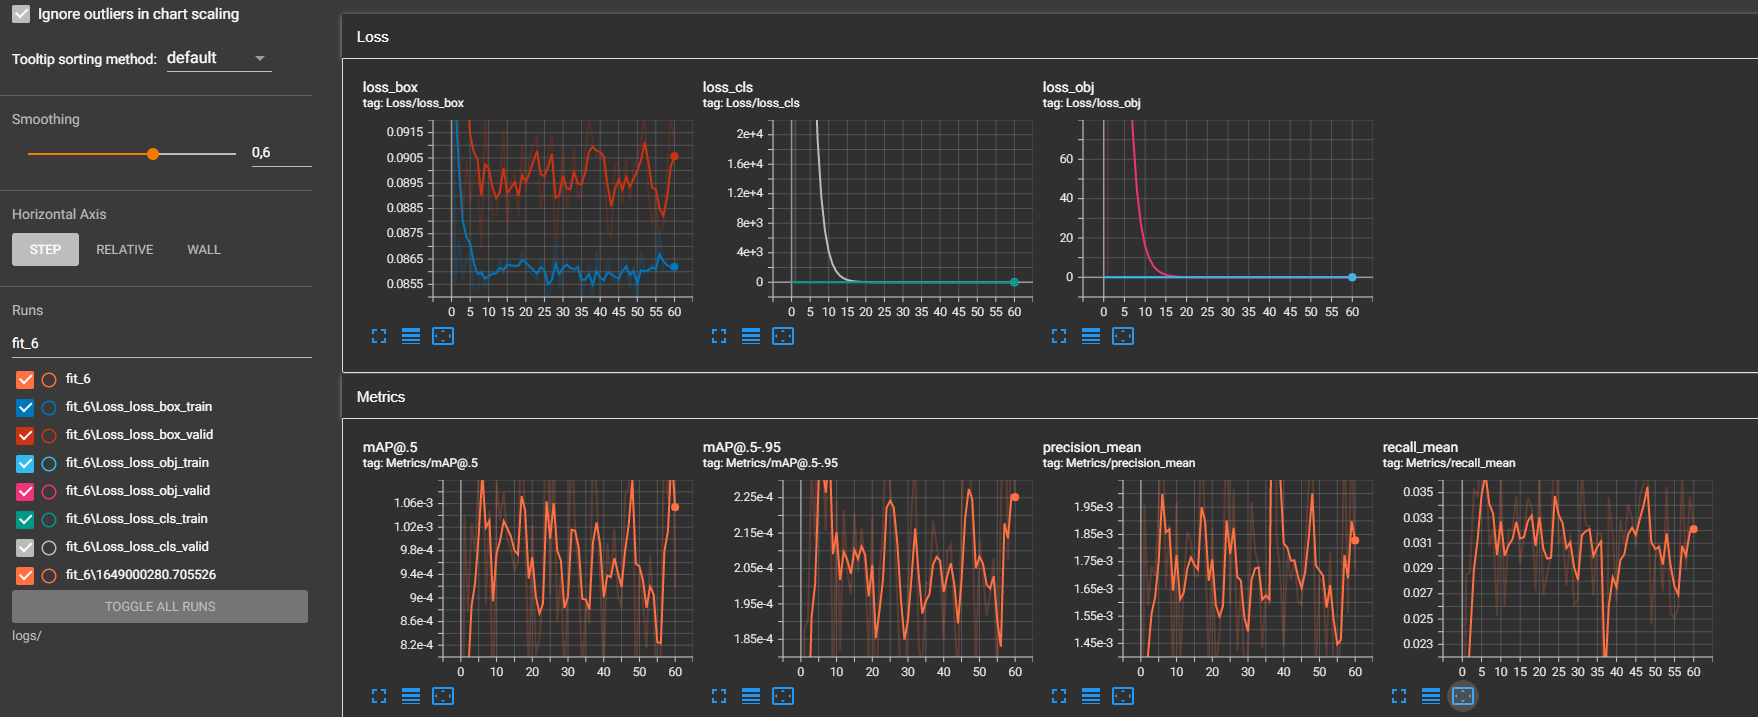

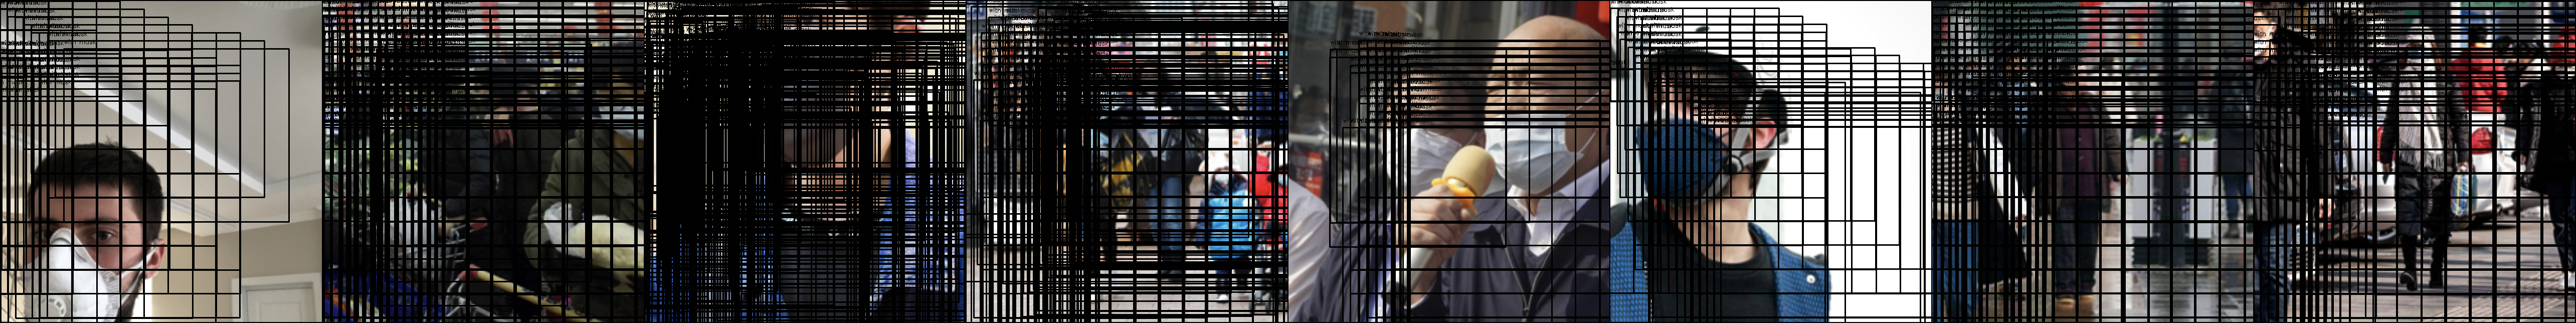

Как видно из результатов TensorBoard, модель где то до 10ой эпохи обучается, а затем loss перестаёт уменьшатся (несмотря на то, что learning rate со временем уменьшается). И в конечном итоге модель не способна предсказывать какие-либо боксы, потому что её уверенность классификации для каждого бокса крайне низкая (в районе 10^-3 степени) и можно считать, что она не может предсказать какой-либо класс (если значительно снизить cotfidanse tashhold, то боксы окажутся везде).

# Выводы

Было предпринято множество попыток обучить модель: замораживать часть слоёв, менять оптимизатор, менять гиперпараметры; но модеть так и не смогла обучиться. Поэтому в последующем модель обучалась встроенными средствами yolov5.
Но данная попытка принесла множество практических знаний - работа с моедлью на половинной точности (autocast), работа с TensorBoard, создание собственного датасета и аугментации для него, а также дало понимание того, как работает обучение yolov5, что в дальнейшем пригодится при обучении встроенными средствами.